In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)

# print(os.getcwd())

In [2]:
## Read raw data
df = pd.read_csv("data/full_dataframe_1node_2hrs_23dims.csv").drop('timestamp', 1)

## Remove redundant prefix name
prefix = "192.168.13.108.443-"
df.columns = [c.replace(prefix, "") for c in df.columns]

## Min-Max normalization
for c in df.columns:
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape((df[c].shape[0], -1)))

### Center points
## Read center of clusters
centers_df = pd.read_csv("data/data_cluster.csv")
feature_cols = sorted(list(set(centers_df.columns).intersection(set(df.columns))))

## get feature cols only
centers_df = centers_df[feature_cols]

## MinMax norm
for c in feature_cols:
    centers_df[c] = MinMaxScaler().fit_transform(centers_df[c].values.reshape((centers_df[c].shape[0], -1)))

## num of clusters   
len_cluster = centers_df.shape[0]

## convert pandas to list
center_list = [centers_df.iloc[i].values for i in range(len_cluster)]



## get feature cols only
df = df[feature_cols]

my_labels = pd.read_csv("data/pred.csv")

df_full = pd.concat([df, my_labels],1)

df_full.head()

CPU1TempTemperatureReading-TemperatureReading  CPU2TempTemperatureReading-TemperatureReading  CUPSSystemUsage-CPUUsage  CUPSSystemUsage-IOUsage  CUPSSystemUsage-MemoryUsage  CUPSSystemUsage-SystemUsage  DIMMSocketA1TemperatureReading-TemperatureReading  DIMMSocketA2TemperatureReading-TemperatureReading  DIMMSocketA3TemperatureReading-TemperatureReading  DIMMSocketA4TemperatureReading-TemperatureReading  DIMMSocketA5TemperatureReading-TemperatureReading  DIMMSocketA6TemperatureReading-TemperatureReading  Fan1RPMReading-RPMReading  Fan2RPMReading-RPMReading  Fan3RPMReading-RPMReading  Fan4RPMReading-RPMReading  Fan5RPMReading-RPMReading  Fan6RPMReading-RPMReading  PowerMetricsTotalStoragePower-SystemPowerConsumption  PowerMetricsTotalStoragePower-TotalCPUPower  PowerMetricsTotalStoragePower-TotalMemoryPower  ThermalTotalPSUHeatDissipation-PowerToCoolRatio  ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower  cluster
0                                            0.0                                            0.0                       0.0                      0.0                          0.0                          0.0                                                1.0                                                0.0                                                1.0                                                0.0                                                0.0                                                0.0                        0.0                        0.0                        0.0                        0.0                        0.0                        0.0                                              0.034091                                     0.231156                                             0.6                                              1.0                                                        1.0        0
1                                            0.0                                            0.0                       0.0                      0.0                          0.0                          0.0                                                1.0                                                0.0                                                1.0                                                0.0                                                0.0                                                0.0                        0.0                        0.0                        0.0                        0.0                        0.0                        0.0                                              0.034091                                     0.231156                                             0.6                                              1.0                                                        1.0        0
2                                            0.0                                            0.0                       0.0                      0.0                          0.0                          0.0                                                1.0                                                0.0                                                1.0                                                0.0                                                0.0                                                0.0                        0.0                        0.0                        0.0                        0.0                        0.0                        0.0                                              0.034091                                     0.231156                                             0.6                                              1.0                                                        1.0        0
3                                            0.0                                            0.0                       0.0                      0.0                          0.0                          0.0                                                1.0

In [3]:
df_full["cluster"].value_counts()

0    1698
6    1278
5     441
8     409
4     383
1     340
3     208
7     195
2      76
Name: cluster, dtype: int64

In [4]:
feature_cols

['CPU1TempTemperatureReading-TemperatureReading',
 'CPU2TempTemperatureReading-TemperatureReading',
 'CUPSSystemUsage-CPUUsage',
 'CUPSSystemUsage-IOUsage',
 'CUPSSystemUsage-MemoryUsage',
 'CUPSSystemUsage-SystemUsage',
 'DIMMSocketA1TemperatureReading-TemperatureReading',
 'DIMMSocketA2TemperatureReading-TemperatureReading',
 'DIMMSocketA3TemperatureReading-TemperatureReading',
 'DIMMSocketA4TemperatureReading-TemperatureReading',
 'DIMMSocketA5TemperatureReading-TemperatureReading',
 'DIMMSocketA6TemperatureReading-TemperatureReading',
 'Fan1RPMReading-RPMReading',
 'Fan2RPMReading-RPMReading',
 'Fan3RPMReading-RPMReading',
 'Fan4RPMReading-RPMReading',
 'Fan5RPMReading-RPMReading',
 'Fan6RPMReading-RPMReading',
 'PowerMetricsTotalStoragePower-SystemPowerConsumption',
 'PowerMetricsTotalStoragePower-TotalCPUPower',
 'PowerMetricsTotalStoragePower-TotalMemoryPower',
 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio',
 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower']

In [5]:
df_full.iloc[0]

CPU1TempTemperatureReading-TemperatureReading                0.000000
CPU2TempTemperatureReading-TemperatureReading                0.000000
CUPSSystemUsage-CPUUsage                                     0.000000
CUPSSystemUsage-IOUsage                                      0.000000
CUPSSystemUsage-MemoryUsage                                  0.000000
CUPSSystemUsage-SystemUsage                                  0.000000
DIMMSocketA1TemperatureReading-TemperatureReading            1.000000
DIMMSocketA2TemperatureReading-TemperatureReading            0.000000
DIMMSocketA3TemperatureReading-TemperatureReading            1.000000
DIMMSocketA4TemperatureReading-TemperatureReading            0.000000
DIMMSocketA5TemperatureReading-TemperatureReading            0.000000
DIMMSocketA6TemperatureReading-TemperatureReading            0.000000
Fan1RPMReading-RPMReading                                    0.000000
Fan2RPMReading-RPMReading                                    0.000000
Fan3RPMReading-RPMRe

## TRAIN

num feature_cols = 23 
Training until validation scores don't improve for 200 rounds
[100]	train's multi_logloss: 0.862283	valid's multi_logloss: 0.862105
[200]	train's multi_logloss: 0.487169	valid's multi_logloss: 0.487076
[300]	train's multi_logloss: 0.28639	valid's multi_logloss: 0.286339
[400]	train's multi_logloss: 0.170963	valid's multi_logloss: 0.170934
[500]	train's multi_logloss: 0.102796	valid's multi_logloss: 0.102779
[600]	train's multi_logloss: 0.0620406	valid's multi_logloss: 0.0620307
[700]	train's multi_logloss: 0.0375207	valid's multi_logloss: 0.0375148
[800]	train's multi_logloss: 0.0227184	valid's multi_logloss: 0.0227148
[900]	train's multi_logloss: 0.0137652	valid's multi_logloss: 0.0137631
[1000]	train's multi_logloss: 0.00834388	valid's multi_logloss: 0.00834259
[1100]	train's multi_logloss: 0.00505893	valid's multi_logloss: 0.00505815
[1200]	train's multi_logloss: 0.0030677	valid's multi_logloss: 0.00306723
[1300]	train's multi_logloss: 0.0018604	valid's multi_

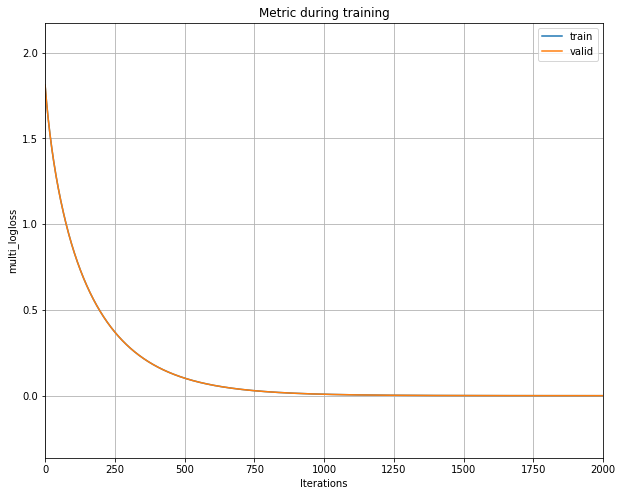

In [6]:
n_jobs = 16
feature_cols = feature_cols
cate_cols = list()
early_stopping = 200

using_SMOTE = False

feature_cols = feature_cols
cate_cols = list()

X_train, X_valid, y_train, y_valid = train_test_split(df_full[feature_cols], df_full["cluster"], test_size=0.33, random_state=2020, stratify = df_full["cluster"])


####################
## RUN THE MODEL ##
###################

## NO need to edit this cell ##

start_time = datetime.now()

random_seed = 2020

print("num feature_cols = {} ".format(len(feature_cols)))

## prepare the model
lgb_params = {
    'boosting_type':'gbdt', 'colsample_bytree':1, #'class_weight': {0 : 1. , 1: weight},
    'importance_type':'gain', 'learning_rate':0.005, 'max_depth':3,
    'min_child_samples':40,# 'min_child_weight':0.001, 'min_split_gain':0.0,
    'n_estimators':2000, 'n_jobs': n_jobs, 'num_leaves':31, #'subsample_freq':16,
    'seed': random_seed, 'reg_alpha':0.0, 'reg_lambda':0.0, 'silent':True,
    'subsample':1, 'subsample_for_bin':200000,  "metric": "multi_logloss" ,'objective':"multiclass"
}

lgb_model = lgb.LGBMClassifier(**lgb_params)


record_store = dict()
lgb_model.fit( X=X_train, y=y_train, feature_name = feature_cols, #categorical_feature = cate_cols, 
              early_stopping_rounds= early_stopping, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              eval_names=["train", "valid"],
              eval_metric= "multi_logloss",
              verbose = 100, callbacks = [lgb.record_evaluation(record_store)])

# calc loss error for valid set
y_pred = lgb_model.predict(X_valid)
y_pred_prob = lgb_model.predict_proba(X_valid)


oof = pd.concat([X_valid, y_valid], 1)
oof['pred'] = y_pred
oof['prob_0'] = y_pred_prob[:,0]
oof['prob_1'] = y_pred_prob[:,1]

# plot learning curve 
f = lgb.plot_metric(record_store, figsize=(10,8))
training_time = datetime.now() - start_time

print("done in ", training_time)

# Check the model on trainning set

In [7]:
pred_train = lgb_model.predict(X_train)
print("Accuracy on trainning set", accuracy_score(y_train, pred_train))

Accuracy on trainning set 1.0


# Check the model on trainning set

In [8]:
pred_valid = lgb_model.predict(X_valid)
print("Accuracy on valid set", accuracy_score(y_valid, pred_valid))

Accuracy on valid set 1.0


In [9]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_valid)

shap_values_np = np.array(shap_values)
shap.initjs()

# Show feature importance for each feature of each class 

In [10]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")
shap_importance

feature_name     cluster_0    cluster_1     cluster_2     cluster_3     cluster_4    cluster_5     cluster_6    cluster_7     cluster_8
0               CPU1TempTemperatureReading-TemperatureReading  2.098864e-08     0.000000  1.934779e-06  0.000000e+00  1.066924e-13     1.219936  8.681944e-14     0.275084  5.190181e-01
1               CPU2TempTemperatureReading-TemperatureReading  1.862111e-07     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00  1218.582241  0.000000e+00
2                                    CUPSSystemUsage-CPUUsage  1.722563e-01     0.000000  4.417336e-07  1.042894e+03  2.556800e+02     0.000000  1.727489e+03   571.161966  8.307452e-03
3                                     CUPSSystemUsage-IOUsage  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
4                                 CUPSSystemUsage-MemoryUsage  7.442958e+00     0.913195  3.418503e-01  4.067702e-01  0.000000e+00     0.876871  3.166629e+00     0.000000  7.296695e-01
5                                 CUPSSystemUsage-SystemUsage  0.000000e+00     0.000000  2.306390e-07  0.000000e+00  1.980849e+03     0.000000  1.825096e+01     0.000000  0.000000e+00
6           DIMMSocketA1TemperatureReading-TemperatureReading  1.927242e+03   951.878662  7.054234e+02  1.938384e+00  6.681866e-01     0.000000  4.177604e+00     0.000014  1.103199e+00
7           DIMMSocketA2TemperatureReading-TemperatureReading  3.341314e-09     0.000000  4.751863e-08  0.000000e+00  1.773931e+03   780.757745  0.000000e+00     0.000000  2.963602e-14
8           DIMMSocketA3TemperatureReading-TemperatureReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
9           DIMMSocketA4TemperatureReading-TemperatureReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
10          DIMMSocketA5TemperatureReading-TemperatureReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
11          DIMMSocketA6TemperatureReading-TemperatureReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
12                                  Fan1RPMReading-RPMReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
13                                  Fan2RPMReading-RPMReading  6.601419e-02     0.000000  1.307782e+02  1.742437e+03  1.214454e+02     0.000000  0.000000e+00     0.000000  2.192476e-01
14                                  Fan3RPMReading-RPMReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
15                                  Fan4RPMReading-RPMReading  2.096709e+00     2.050877  2.299627e-04  1.521405e+00  3.864775e+02     3.258470  9.984336e+02     1.584531  2.519513e+00
16                                  Fan5RPMReading-RPMReading  1.784272e-07     0.000000  5.183031e-05  0.000000e+00  1.627910e-06  2748.036574  0.000000e+00     0.000000  0.000000e+00
17                                  Fan6RPMReading-RPMReading  0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.000000  0.000000e+00
18       PowerMetricsTotalStoragePower-SystemPowerConsumption  1.179205e-01  1871.844450  5.741457e+02  4.234979e-09  1.082412e-01     0.000000  6.937715e-01   706.110176  3.497557e+03
19                PowerMetricsTotalStoragePower-TotalCPUPower  8.980887e-08     0.100602  5.401841e-07  5.771509e-09  9.004355e-10     0.000000  0.000000e+00     0.000021  0.000000e+00
20             PowerMetricsTotalStoragePower-TotalMemoryPower  0.000000e+00     0.000000  3.678194e-07  0.000000e+00  0.000000e+00     0.000000  0.000000e+00     0.

In [11]:
import plotly.graph_objects as go

x = list(range(len_cluster))

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each cluster, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

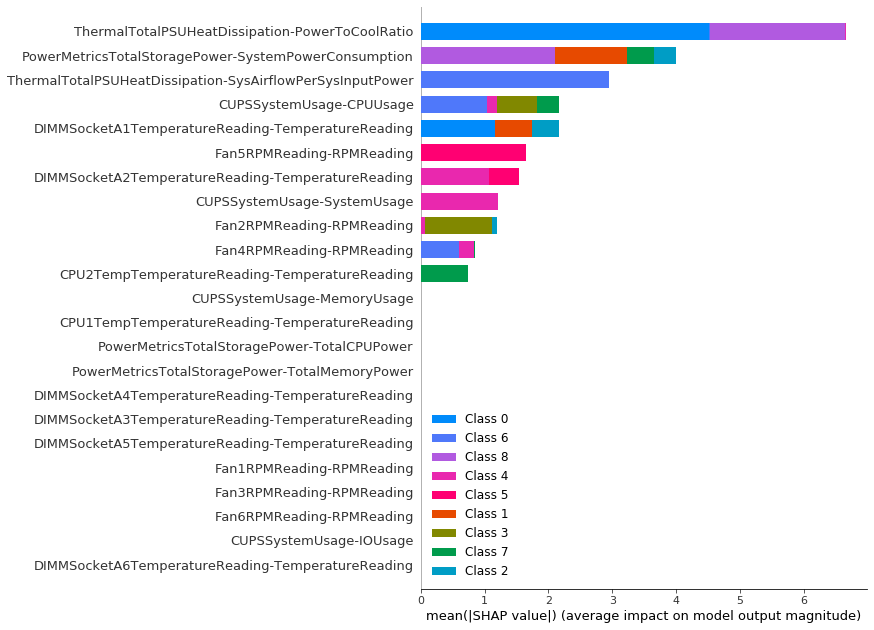

In [12]:
## Feature importance of each feature, colored by cluster

shap.summary_plot(shap_values, X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")

Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


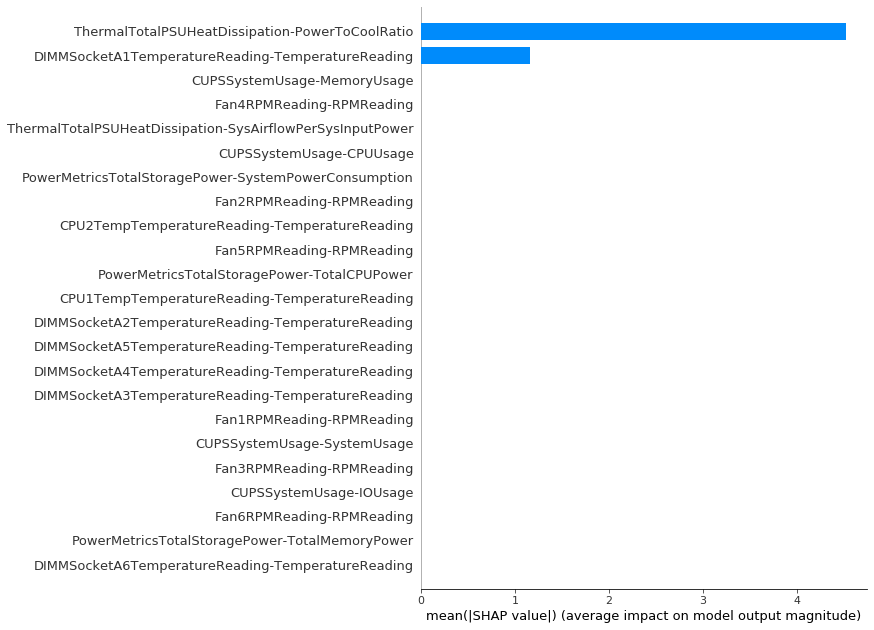



cluster 1


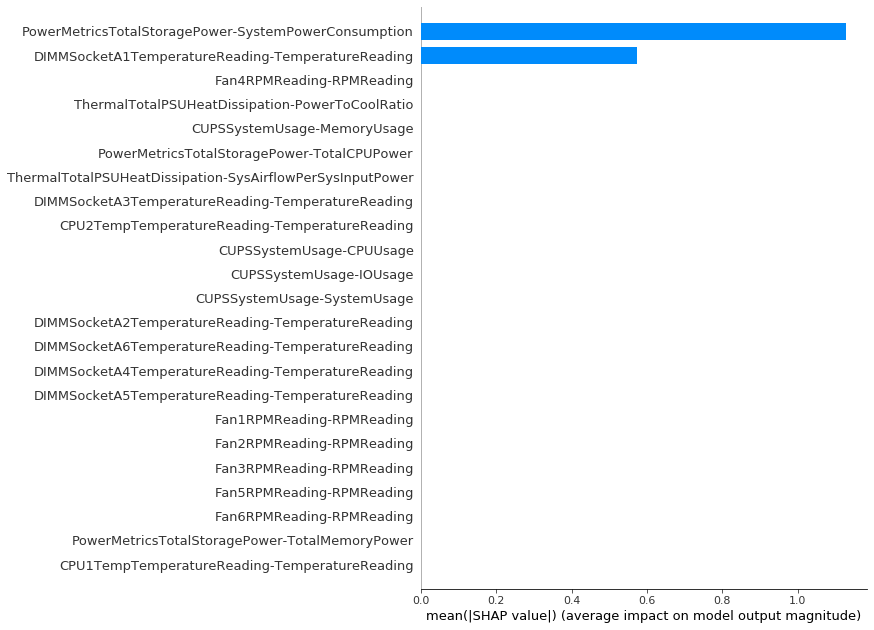



cluster 2


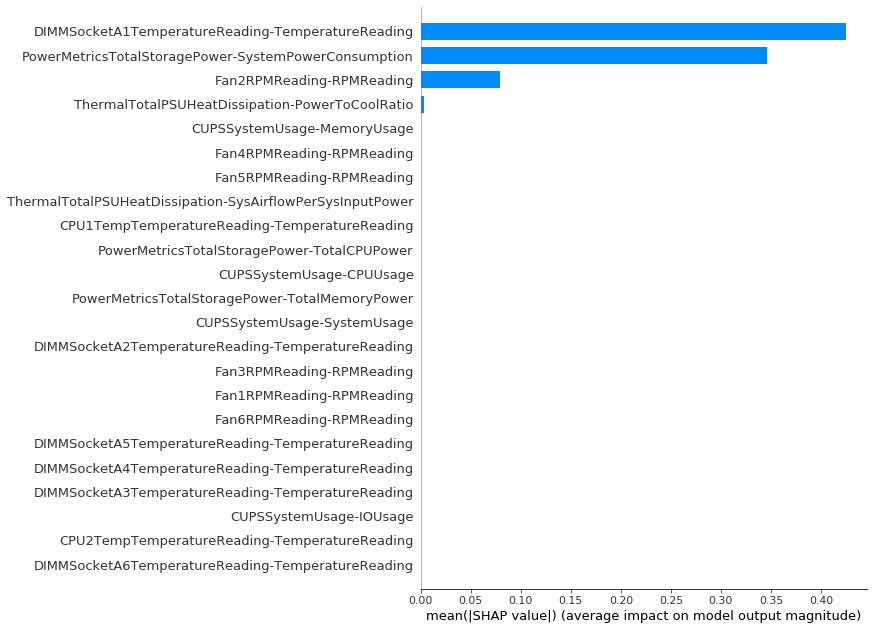



cluster 3


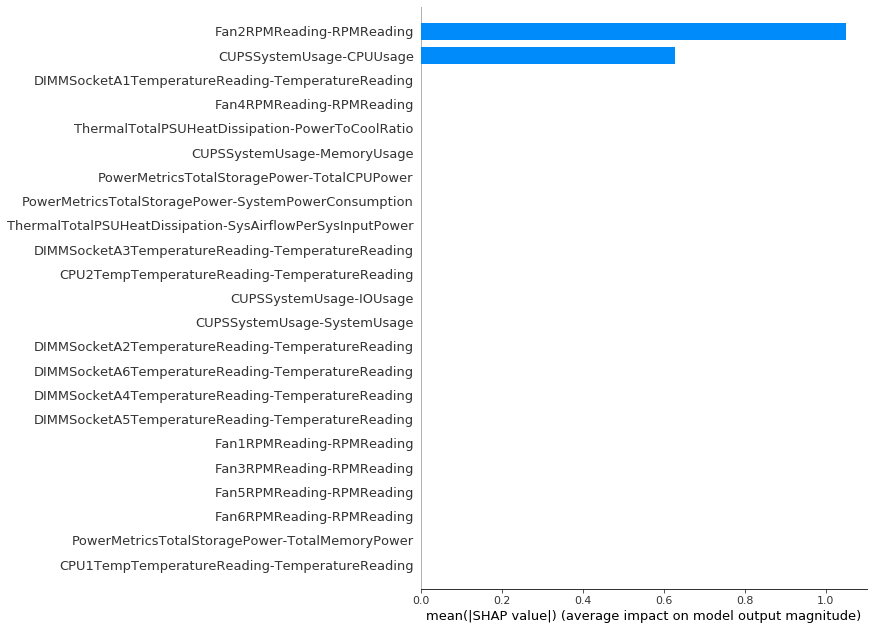



cluster 4


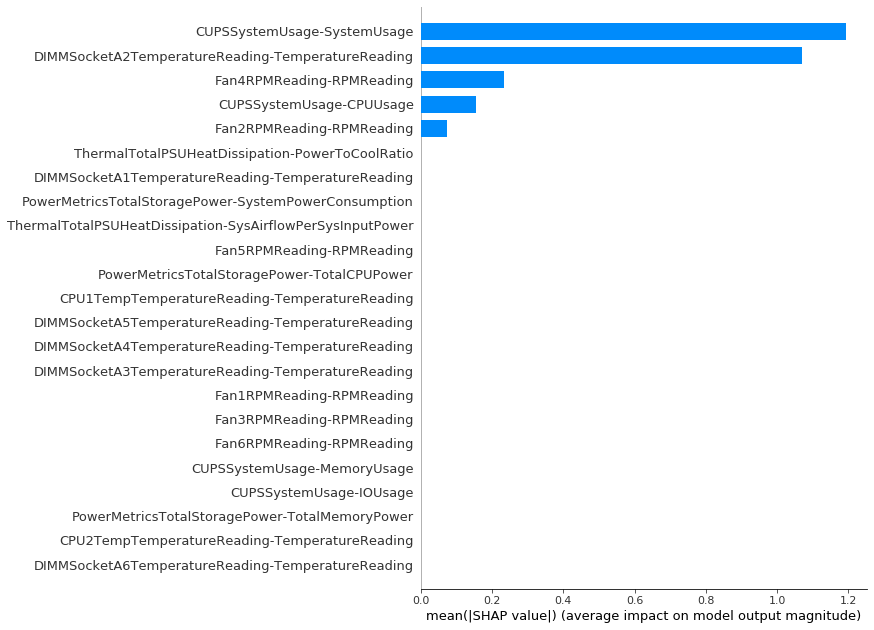



cluster 5


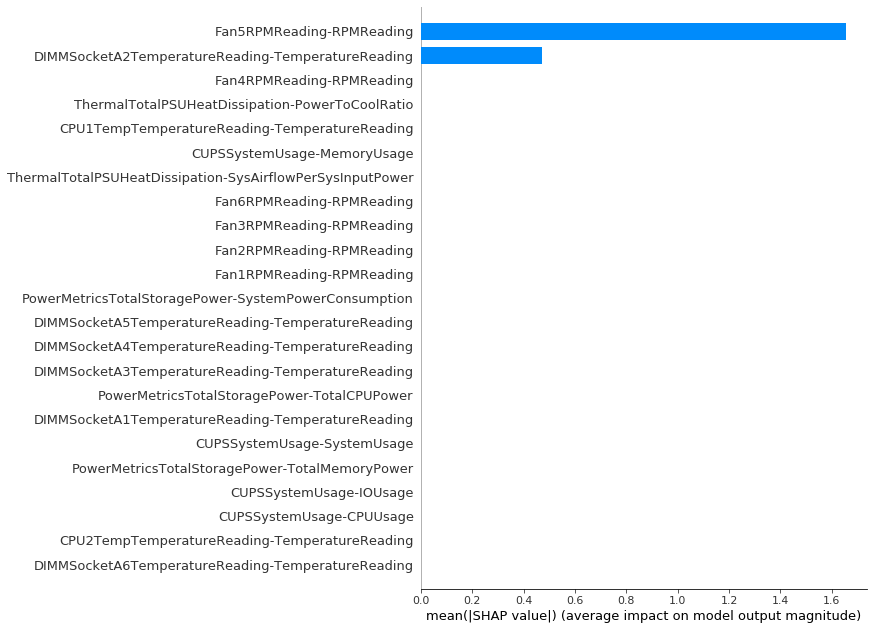



cluster 6


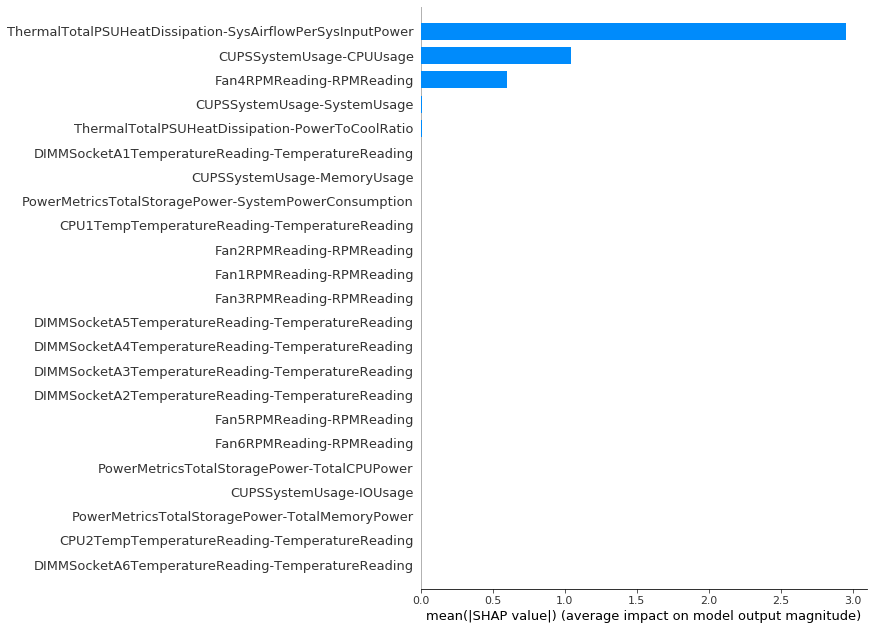



cluster 7


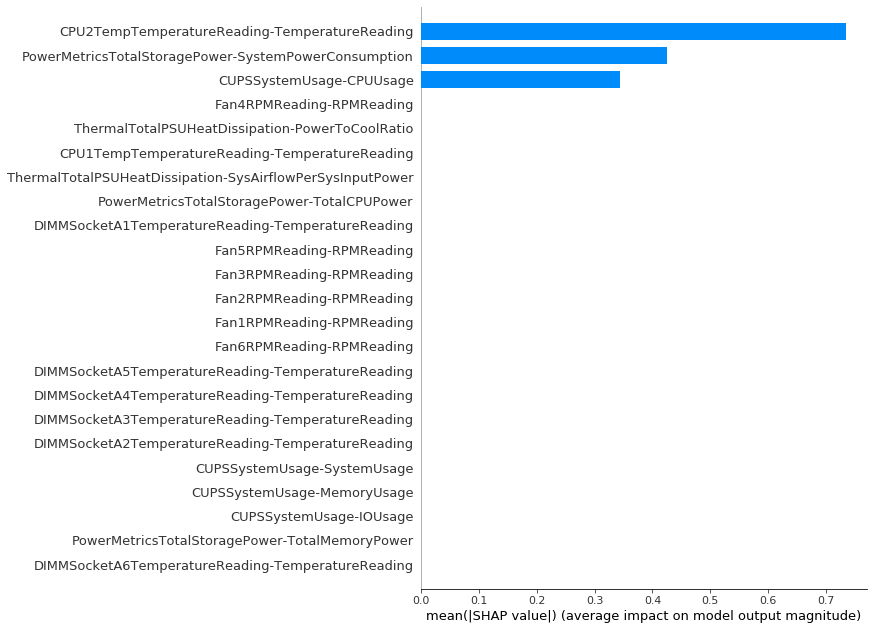



cluster 8


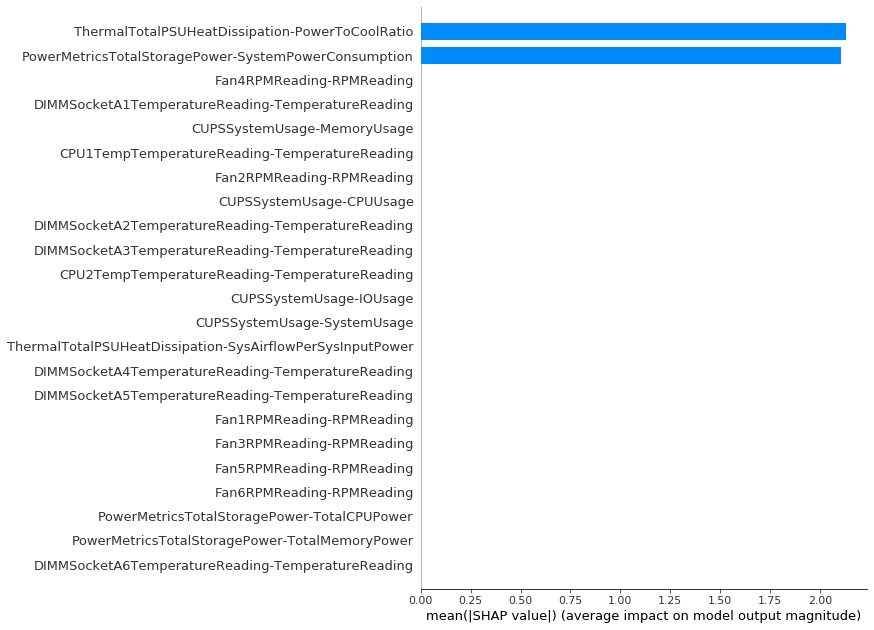

In [13]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display =  len(feature_cols), show=False, plot_type = "bar")
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [14]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


In [15]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]
print("pred: Cluster", pred_valid[i])
for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name="cluster "+str(i), mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

pred: Cluster 6


cluster 0


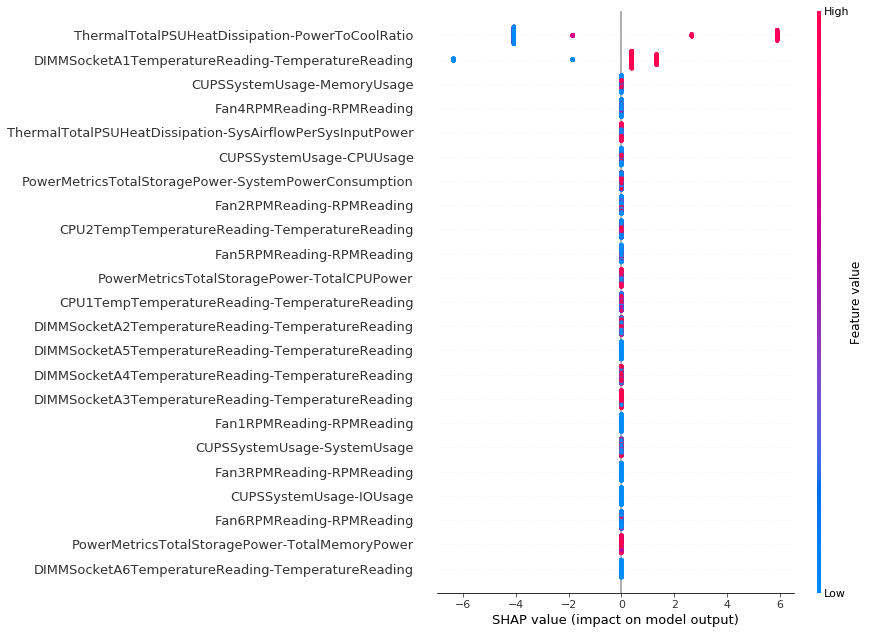



cluster 1


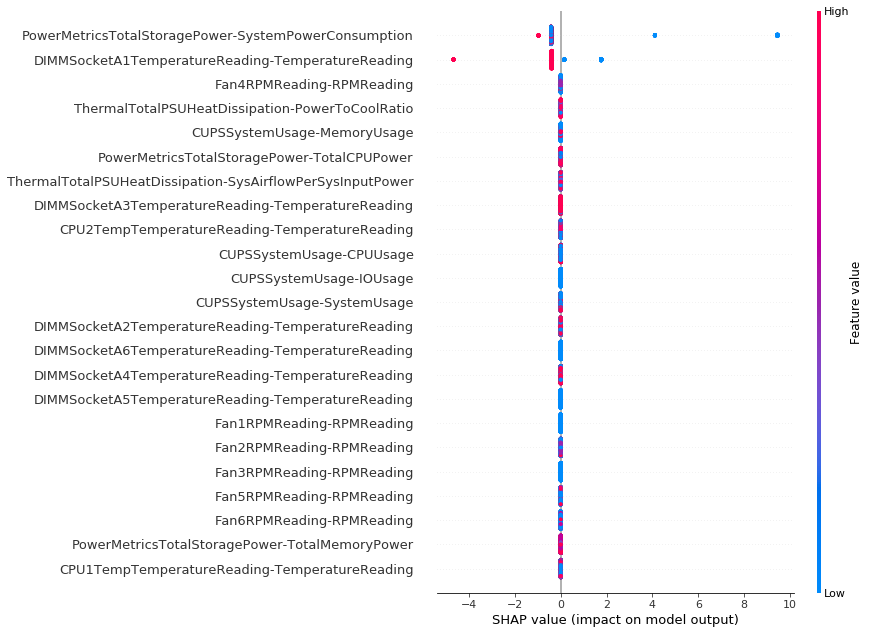



cluster 2


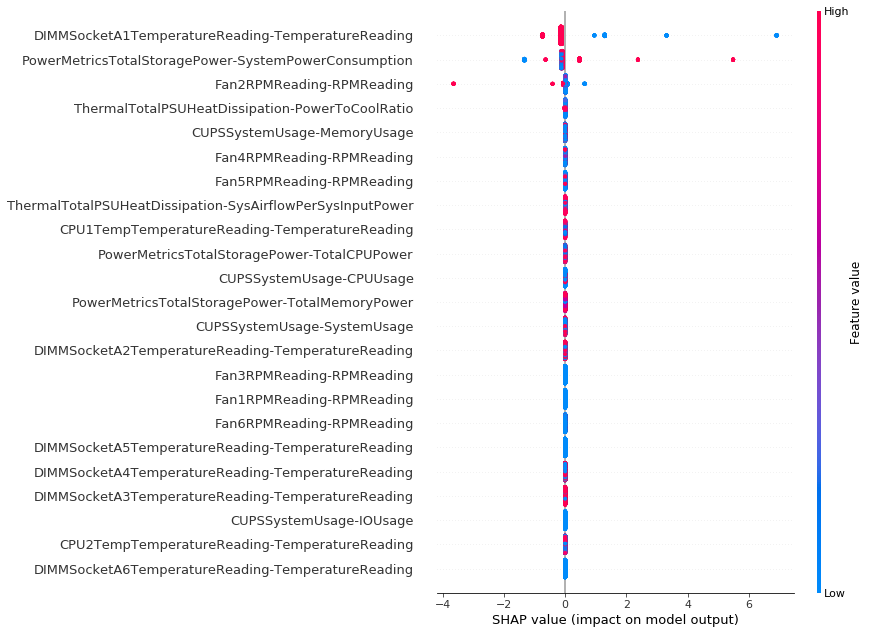



cluster 3


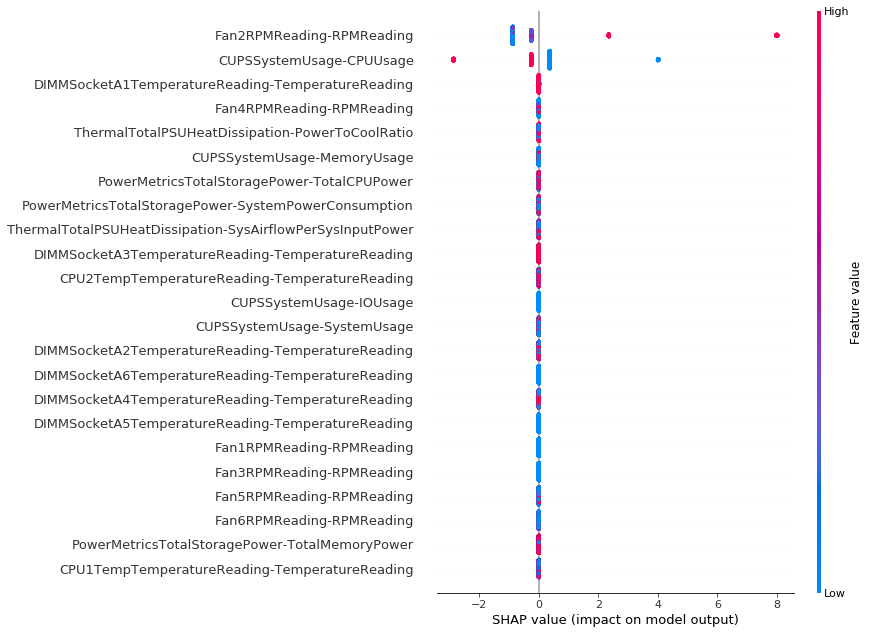



cluster 4


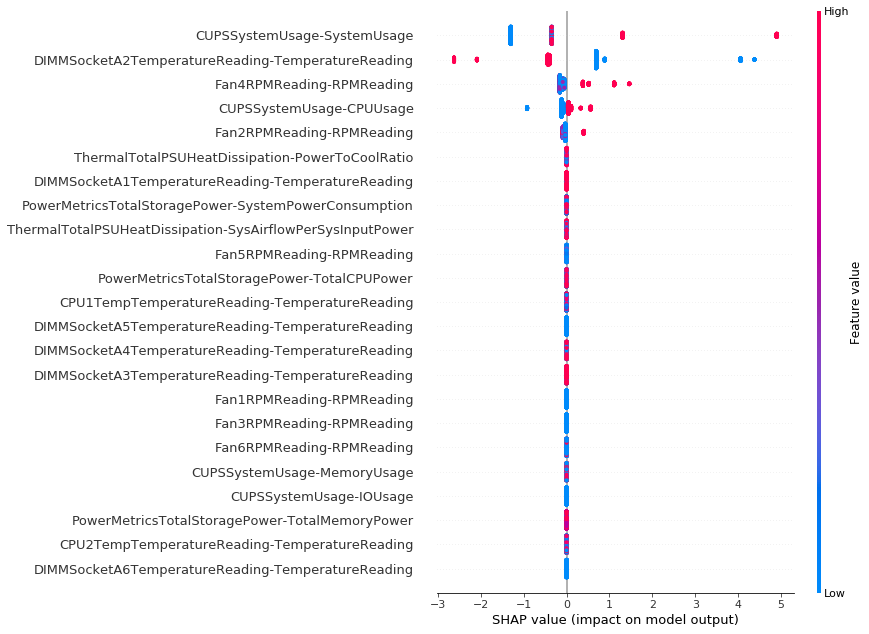



cluster 5


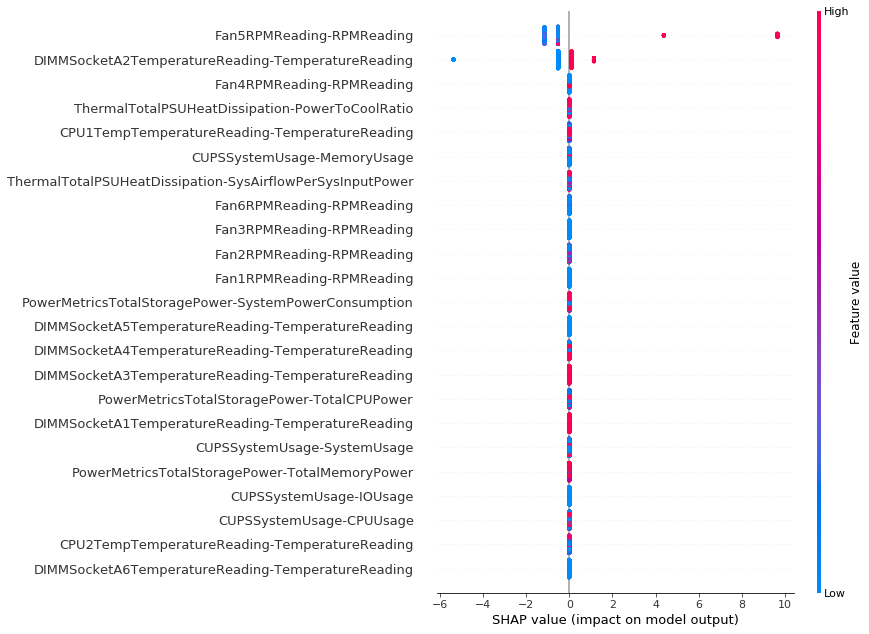



cluster 6


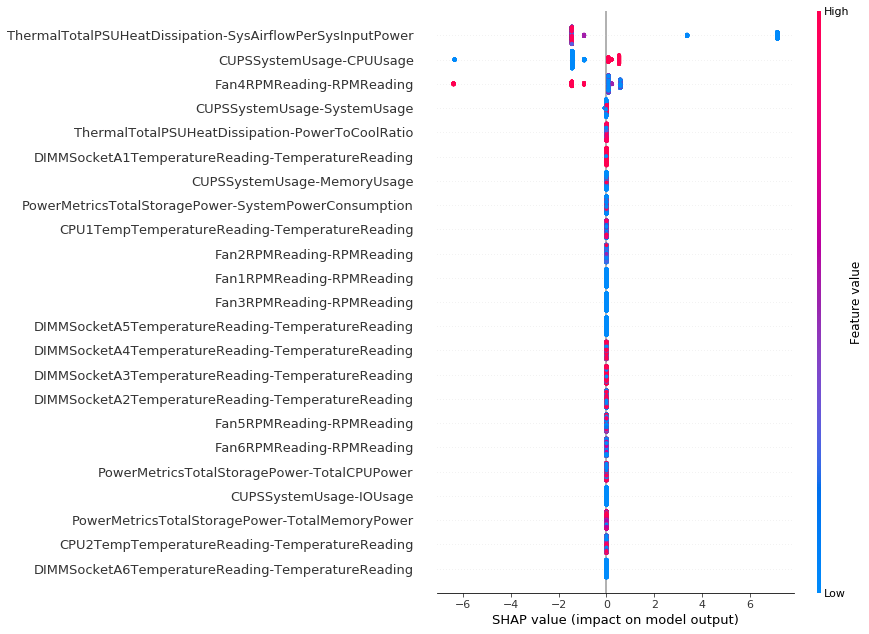



cluster 7


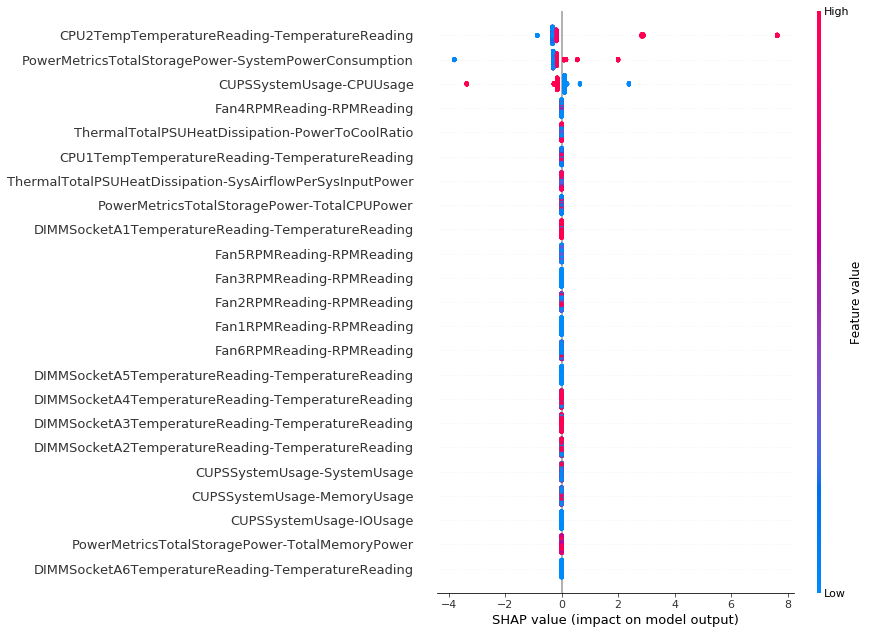



cluster 8


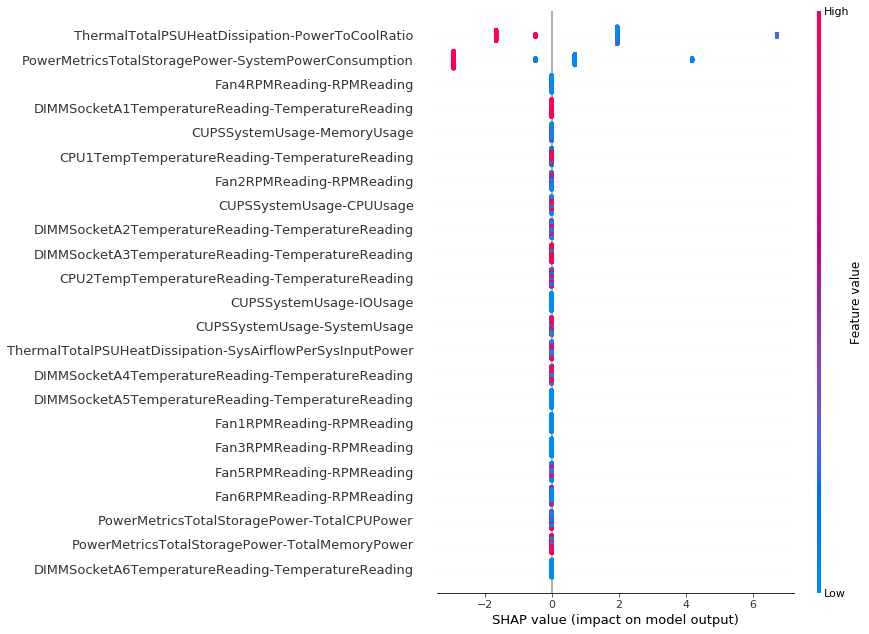

In [16]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_valid, max_display = len(feature_cols), show=False, plot_type = "dot")
    print("cluster", i)
    plt.show(f)
    print("\n")